In [6]:
from paretoset import paretoset
import pandas as pd

In [7]:
def dominates(row, candidateRow):
    return sum([row[x] >= candidateRow[x] for x in range(len(row))]) == len(row)


def simple_cull(inputPoints):
    paretoPoints = set()
    candidateRowNr = 0
    dominatedPoints = set()
    while True:
        candidateRow = inputPoints[candidateRowNr]
        inputPoints.remove(candidateRow)
        rowNr = 0
        nonDominated = True
        while len(inputPoints) != 0 and rowNr < len(inputPoints):
            row = inputPoints[rowNr]
            if dominates(candidateRow[1], row[1]):
                # If it is worse on all features remove the row from the array
                inputPoints.remove(row)
                dominatedPoints.add(tuple(tuple(i) for i in row))
            elif dominates(row[1], candidateRow[1]):
                nonDominated = False
                dominatedPoints.add(tuple(tuple(i) for i in candidateRow))
                rowNr += 1
            else:
                rowNr += 1

        if nonDominated:
            # add the non-dominated point to the Pareto frontier
            paretoPoints.add(tuple(tuple(i) for i in candidateRow))

        if len(inputPoints) == 0:
            break
    return paretoPoints, dominatedPoints

In [8]:
def pareto_position_country_season(df,position,country,categories):
    data = df.loc[df['Nation'] == country].loc[df["Pos"] == position]

    ids = ['Player']
    ids_points = data[ids].to_numpy().tolist()

    points = data[categories].to_numpy().tolist()
    input_points = list(zip(ids_points,points))
    pareto, _ = simple_cull(input_points)

    return pareto

In [9]:
def get_allstats(minutes):
    # cargamos todos los datos estadisticos relativos a las distintas caracteristicas de los jugadores
    def_df_full = pd.read_csv("../data/defensive_2022.csv")
    pass_df_full = pd.read_csv("../data/passing_2022.csv")
    poss_df_full = pd.read_csv("../data/possession_2022.csv")
    shoot_df_full = pd.read_csv("../data/shooting_2022.csv")
    goalshoot_df_full = pd.read_csv("../data/goal_shot_creation_2022.csv")
    passingType_df_full = pd.read_csv("../data/passing_type_2022.csv")

    # se eliminan algunas variables comunes o que no interesen
    def_df_full.drop(["Rk", "Born", "Matches", "Pressure_%", "vsDriblers_Tkl%", "Tkl+Int", "test"], axis=1,
                     inplace=True)

    pass_df_full.drop(
        ["Rk", "Player", "Squad", "Comp", "Born", "Matches", "Age", "Pos", "Nation", "90s", "Ttl_Pass_Cmpl%",
         "Short_Pass_Cmpl%", "Medium_Pass_Cmp%", "Long_Pass_Cmp%", "A-xA", "test"],
        axis=1, inplace=True)

    poss_df_full["Poss_Fail"] = poss_df_full["Miss_Poss"] + poss_df_full["Tackled"]
    poss_df_full.drop(["Rk", "Player", "Squad", "Comp", "Born", "Matches", "Age", "Pos", "Nation", "90s",
                       "Megs", "Dribbles_Succ%", "Tackled", "Miss_Poss", "Succ_RecPass%", "test"
                       ], axis=1, inplace=True)

    shoot_df_full.drop(["Rk", "Player", "Squad", "Comp", "Born", "Matches", "Age", "Pos", "Nation", "90s",
                        "SoT%", "Sh/90", "SoT/90", "FK", "PK", "PKatt", "npxG", "G-xG", "np:G-xG", "test"], axis=1,
                       inplace=True)

    goalshoot_df_full.drop(["Rk", "Player", "Squad", "Comp", "Born", "Matches", "Age", "Pos", "Nation", "90s",
                            "SCA90", "GCA90", "test"], axis=1, inplace=True)

    passingType_df_full.drop(["Rk", "Player", "Squad", "Comp", "Born", "Matches", "Age", "Pos", "Nation", "90s",
                              "Att", "Live", "Dead", "FK", "CK", "Cmp", "Off", "Out", "Int", "Blocks", "test"], axis=1,
                             inplace=True)

    # realizamo un preprocesado a algunas columnas de interés
    def_df_full['Pos'] = def_df_full['Pos'].str[0:2]
    def_df_full['Nation'] = def_df_full['Nation'].str[0:2]
    def_df_full["Player"] = def_df_full["Player"].str.split("\\", n=1, expand=True)[0]

    # juntamos todos los conjuntos de datos en uno mismo
    allstats_df = pd.concat(
        [def_df_full, pass_df_full, poss_df_full, shoot_df_full, goalshoot_df_full, passingType_df_full], axis=1)
    # filtramos por aquellos jugadores que no sean porteros
    allstats_df["MP"] = allstats_df["90s"] * 90
    allstats_df.fillna(0, inplace=True)
    allstats_df = allstats_df[(allstats_df['Pos'] != 'GK') & (allstats_df["MP"] >= minutes)].reset_index()

    allstats_df.drop(["index", "MP"], axis=1, inplace=True)
    return allstats_df

In [10]:
df_all_stats = get_allstats(600)

In [11]:
df_all_stats.head()

,Player,Nation,Pos,Squad,Comp,Age,90s,tackles_Tkl,tackles_TklW,tackles_Def 3rd,...,Str,Ground,Low,High,Left,Right,Head,TI,Other,Out.1
0,Max Aarons,en,DF,Norwich City,eng Premier League,21.0,32.0,2.16,1.16,1.56,...,0.0,26.5,9.59,8.94,4.91,29.00,0.91,9.72,0.06,0.88
1,Yunis Abdelhamid,ma,DF,Reims,fr Ligue 1,33.0,33.1,1.87,1.39,1.24,...,0.0,35.3,3.78,7.95,31.70,12.10,1.48,0.42,0.12,0.97
2,Salis Abdul Samed,gh,MF,Clermont Foot,fr Ligue 1,21.0,27.4,2.01,1.24,0.91,...,0.0,52.6,4.71,3.72,4.82,53.10,1.90,0.15,0.29,0.58
3,Laurent Abergel,fr,MF,Lorient,fr Ligue 1,28.0,32.8,3.57,2.23,1.49,...,0.0,37.6,5.64,6.65,4.48,43.90,0.73,0.15,0.15,0.55
4,Dickson Abiama,ng,FW,Greuther Fürth,de Bundesliga,22.0,8.1,1.73,0.86,0.37,...,0.0,10.7,3.95,2.47,3.33,9.38,2.35,0.00,0.37,0.62


In [12]:
pareto = pareto_position_country_season(df_all_stats,'FW','pt',['tackles_Def 3rd','Pressure_Def 3rd', 'Pressure_Att 3rd', 'Blocks', 'Int',
                                                                'Ttl_Pass_Compl', 'Ttl_Pass_Att', 'Ttl_Dist_Pass', 'Prgsv_Dist',
                                                                'Medium_Pass_Cmp', 'Medium_Pass_Att', 'Long_Pass_Cmp', 'Long_Pass_Att',
                                                                'Touches_Ttl', 'Touches_Def3rd', 'Touches_Mid3rd', 'Touches_AttPen',
                                                                'Touches_Live', 'CPA', 'Prog_Pass', 'Poss_Fail', 'Gls', 'Sh', 'SoT', 'xG'])
for player in pareto:
    print(player[0][0],end=", ")

Gelson Martins, João Félix, Rafael Leão, Daniel Podence, Cristiano Ronaldo, Gonçalo Guedes, André Silva, Francisco Trincão, Diogo Jota, Tiago Tomás, 

In [13]:
pareto = pareto_position_country_season(df_all_stats,'DF','pt',['Pressure_Press', 'Pressure_Mid 3rd'])
for player in pareto:
    print(player[0][0],end=", ")

Mathias Pereira Lage, 

In [15]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [16]:
cols = df_all_stats.iloc[:,7:].columns.tolist()
scaler = StandardScaler()

df_all_stats[cols] = scaler.fit_transform(df_all_stats[cols])
df_all_stats.head()

,Player,Nation,Pos,Squad,Comp,Age,90s,tackles_Tkl,tackles_TklW,tackles_Def 3rd,...,Str,Ground,Low,High,Left,Right,Head,TI,Other,Out.1
0,Max Aarons,en,DF,Norwich City,eng Premier League,21.0,32.0,0.449747,0.114862,1.317318,...,-0.317109,-0.319769,1.278281,0.247101,-0.567037,0.161628,-1.068953,2.323758,-0.844927,0.405314
1,Yunis Abdelhamid,ma,DF,Reims,fr Ligue 1,33.0,33.1,0.090539,0.551489,0.713288,...,-0.317109,0.351060,-0.805283,-0.020277,1.269846,-0.829781,-0.430892,-0.493000,-0.590589,0.670640
2,Salis Abdul Samed,gh,MF,Clermont Foot,fr Ligue 1,21.0,27.4,0.263950,0.266732,0.090382,...,-0.317109,1.669849,-0.471770,-1.162708,-0.573208,1.575412,0.039259,-0.574777,0.130033,-0.479108
3,Laurent Abergel,fr,MF,Lorient,fr Ligue 1,28.0,32.8,2.196244,2.146126,1.185186,...,-0.317109,0.526390,-0.138256,-0.371378,-0.596521,1.035710,-1.270446,-0.574777,-0.463421,-0.567550
4,Dickson Abiama,ng,FW,Greuther Fürth,de Bundesliga,22.0,8.1,-0.082872,-0.454651,-0.928919,...,-0.317109,-1.524212,-0.744319,-1.500306,-0.675372,-0.989345,0.542991,-0.620209,0.469150,-0.361185


In [41]:
pareto = pareto_position_country_season(df_all_stats,'DF','pt',['Pressure_Press', 'Pressure_Mid 3rd', 'Pressure_Att 3rd', 'Blocks_Sh', 'Clr',
                                                                'Prgsv_Dist', 'Medium_Pass_Cmp'])
for player in pareto:
    print(player[0][0],end=", ")

Diogo Dalot, Cédric Soares, Mathias Pereira Lage, Nuno Mendes, Tiago Djaló, João Cancelo, Rúben Dias, Raphaël Guerreiro, Ricardo Pereira, Rúben Vezo, José Fonte, Thierry Correia, Mário Rui, Guilherme Ramos, Nuno Tavares, Domingos Duarte, 

C:\Users\Ricardo\anaconda3\envs\deepL\lib\site-packages\matplotlib\collections.py:1039: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


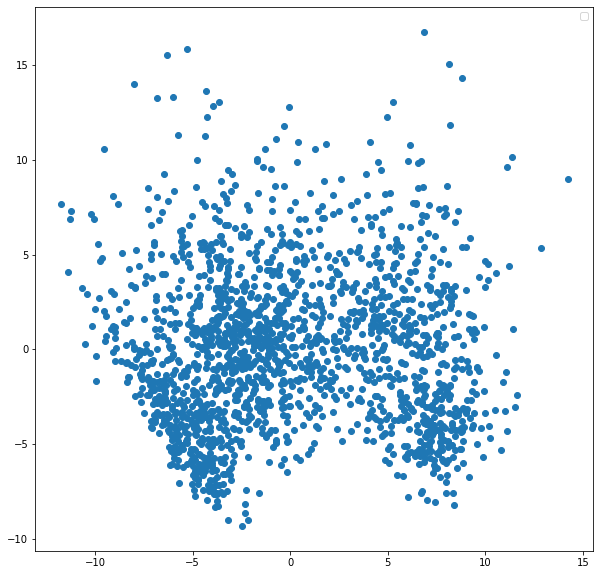

In [17]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import seaborn as sns

data = df_all_stats[cols]

pca = PCA(n_components=2)
pca.fit(data)
data_pca = pca.transform(data)


plt.figure(figsize = (10,10))
scatter = plt.scatter(data_pca[:,0], data_pca[:,1])
plt.legend(*scatter.legend_elements())
plt.show()

In [18]:
df_all_stats["x"] = data_pca[:,0]
df_all_stats["y"] = data_pca[:,1]
#df_all_stats["2"] = data_pca[:,2]
df_all_stats


,Player,Nation,Pos,Squad,Comp,Age,90s,tackles_Tkl,tackles_TklW,tackles_Def 3rd,...,Low,High,Left,Right,Head,TI,Other,Out.1,x,y
0,Max Aarons,en,DF,Norwich City,eng Premier League,21.0,32.0,0.449747,0.114862,1.317318,...,1.278281,0.247101,-0.567037,0.161628,-1.068953,2.323758,-0.844927,0.405314,-2.454308,-0.744601
1,Yunis Abdelhamid,ma,DF,Reims,fr Ligue 1,33.0,33.1,0.090539,0.551489,0.713288,...,-0.805283,-0.020277,1.269846,-0.829781,-0.430892,-0.493000,-0.590589,0.670640,-4.836904,-3.337828
2,Salis Abdul Samed,gh,MF,Clermont Foot,fr Ligue 1,21.0,27.4,0.263950,0.266732,0.090382,...,-0.471770,-1.162708,-0.573208,1.575412,0.039259,-0.574777,0.130033,-0.479108,-3.368659,2.139516
3,Laurent Abergel,fr,MF,Lorient,fr Ligue 1,28.0,32.8,2.196244,2.146126,1.185186,...,-0.138256,-0.371378,-0.596521,1.035710,-1.270446,-0.574777,-0.463421,-0.567550,-2.476723,3.318348
4,Dickson Abiama,ng,FW,Greuther Fürth,de Bundesliga,22.0,8.1,-0.082872,-0.454651,-0.928919,...,-0.744319,-1.500306,-0.675372,-0.989345,0.542991,-0.620209,0.469150,-0.361185,7.166982,-3.885040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1756,Martín Zubimendi,es,MF,Real Sociedad,es La Liga,22.0,28.8,0.400201,0.019943,0.147009,...,-0.367771,-0.114804,-0.149470,0.542939,-0.061488,-0.620209,0.087644,0.257910,-3.249607,-0.821645
1757,Szymon Żurkowski,pl,MF,Empoli,it Serie A,23.0,25.6,1.205324,1.538645,0.807668,...,-0.816042,-1.143802,-0.493672,0.108831,-1.304028,-0.559633,-0.421031,-0.331704,1.300566,0.359570
1758,Martin Ødegaard,no,MF,Arsenal,eng Premier League,22.0,30.9,-0.504013,-0.549570,-1.325314,...,-0.163359,-0.576638,2.202344,-1.294980,-0.856266,-0.511173,0.681097,-0.744434,3.551227,5.388898
1759,Milan Đurić,ba,FW,Salernitana,it Serie A,31.0,24.1,-1.916074,-1.764532,-1.476322,...,1.532899,0.174180,-0.792620,-1.013983,3.576580,-0.595978,7.675375,-0.980280,6.647882,-4.806590


In [20]:
paretoset_hotels

,Player,Nation,Pos,Squad,Comp,Age,90s,tackles_Tkl,tackles_TklW,tackles_Def 3rd,...,Low,High,Left,Right,Head,TI,Other,Out.1,x,y
264,João Cancelo,pt,DF,Manchester City,eng Premier League,27.0,35.9,0.846115,0.760310,-0.003998,...,2.752197,1.667713,-0.183753,2.514024,0.934783,1.793723,-0.293862,2.233119,-4.310088,13.599759
643,Raphaël Guerreiro,pt,DF,Dortmund,de Bundesliga,27.0,19.9,0.573612,0.779294,0.562280,...,1.676346,0.695431,3.470815,-1.324312,-0.621191,1.572623,-0.039525,-0.125339,-3.031093,8.375959
1275,Mathias Pereira Lage,pt,DF,Angers,fr Ligue 1,24.0,11.6,0.226790,-0.131927,-0.003998,...,1.855655,0.230896,-0.549210,0.138163,0.128811,1.963334,0.341981,-0.154820,0.906815,0.686655
1277,Ricardo Pereira,pt,DF,Leicester City,eng Premier League,27.0,11.0,2.840341,2.222061,2.487627,...,1.963240,0.695431,-0.442247,0.824523,-0.565220,2.187463,-1.099264,-1.127684,-2.514893,4.320226
1577,Nuno Tavares,pt,DF,Arsenal,eng Premier League,21.0,13.1,-0.330602,-0.340749,-0.324889,...,1.819793,-0.168820,1.626389,-1.114298,-0.554026,1.714975,-0.760148,0.965448,-0.212469,2.561519


C:\Users\Ricardo\anaconda3\envs\deepL\lib\site-packages\matplotlib\collections.py:1039: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


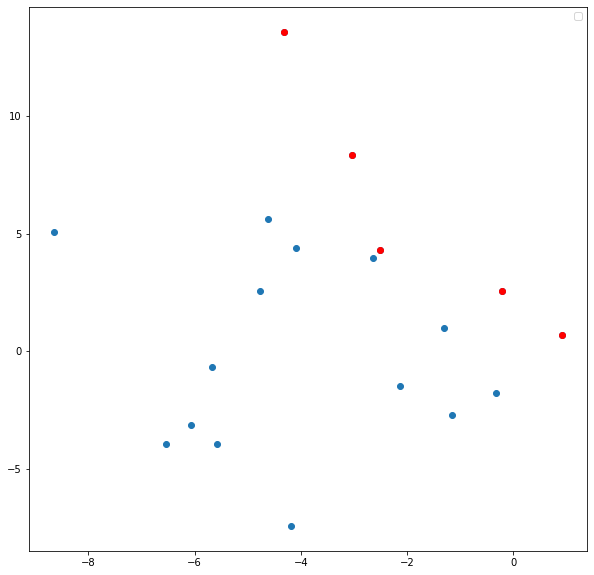

In [19]:
data_pt = df_all_stats.loc[df_all_stats.Nation == "pt"].loc[df_all_stats.Pos == "DF"]

mask = paretoset(data_pt[['x', 'y']], sense=["max", "max"])
paretoset_hotels = data_pt[mask]
paretoset_hotels

plt.figure(figsize = (10,10))
scatter = plt.scatter(data_pt.x, data_pt.y)
plt.legend(*scatter.legend_elements())
plt.scatter(paretoset_hotels.x, paretoset_hotels.y, color="red")
plt.show()

In [21]:
df_all_stats["MP"] = df_all_stats["90s"]*90
df_filtered = df_all_stats.loc[df_all_stats["MP"]> 700].copy()

data_df = df_filtered[['Pressure_Press', 'Pressure_Mid 3rd', 'Pressure_Att 3rd', 'Blocks_Sh', 'Clr',
                       'Prgsv_Dist', 'Medium_Pass_Cmp', 'Medium_Pass_Att', 'Touches_DefPen',
                       'Touches_Def3rd', 'Touches_AttPen', 'Prog_Pass', 'Poss_Fail', 'Sh', 'SoT', 'xG',
                       'SCA', 'shot_PassLive']]

pca = PCA(n_components=3)
pca.fit(data_df)
data_pca = pca.transform(data_df)

df_filtered["x"] = data_pca[:,0]
df_filtered["y"] = data_pca[:,1]
df_filtered["z"] = data_pca[:,2]

pareto = pareto_position_country_season(df_filtered,'DF','pt',["x","y","z"])
for player in pareto:
    print(player[0][0],end=", ")

Domingos Duarte, Mathias Pereira Lage, João Cancelo, Nélson Semedo, Guilherme Ramos, Nuno Tavares, Rúben Vezo, Rúben Dias, José Fonte, 

In [22]:


data_mf = df_filtered[['Blocks', 'GCA', 'Pressure_Att 3rd', 'Pressure_Def 3rd', 'Pressure_Mid 3rd',
                        'Pressure_Press', 'Pressure_Succ', 'Prgsv_Dist', 'SCA', 'Touches_Att3rd',
                        'Touches_Def3rd', 'Touches_Mid3rd', 'Ttl_Dist_Pass', 'Ttl_Pass_Compl',
                        'tackles_Att 3rd', 'tackles_Def 3rd', 'tackles_Mid 3rd', 'vsDriblers_Att',
                        'vsDriblers_Past']]

pca = PCA(n_components=3)
pca.fit(data_mf)
data_pca = pca.transform(data_mf)

df_filtered["x"] = data_pca[:,0]
df_filtered["y"] = data_pca[:,1]
df_filtered["z"] = data_pca[:,2]

pareto = pareto_position_country_season(df_filtered,'MF','pt',["x","y","z"])
for player in pareto:
    print(player[0][0] ,end=", ")



Xeka, William Carvalho, Renato Sanches, Florentino Luís, Rúben Neves, Sérgio Oliveira, Danilo Pereira, João Moutinho, Bernardo Silva, 

In [92]:
row1 = df_filtered.loc[df_filtered.Player=="William Carvalho"][["x","y","z"]]

row2 = df_filtered.loc[df_filtered.Player=="David Pereira da Costa"][["x","y","z"]]

In [23]:
data_fw = df_filtered[['tackles_Def 3rd', 'Pressure_Def 3rd', 'Pressure_Att 3rd', 'Blocks', 'Int',
                        'Ttl_Pass_Compl', 'Ttl_Pass_Att', 'Ttl_Dist_Pass', 'Prgsv_Dist',
                        'Medium_Pass_Cmp', 'Medium_Pass_Att', 'Long_Pass_Cmp', 'Long_Pass_Att',
                        'Touches_Ttl', 'Touches_Def3rd', 'Touches_Mid3rd', 'Touches_AttPen',
                        'Touches_Live', 'CPA', 'Prog_Pass', 'Poss_Fail', 'Gls', 'Sh', 'SoT', 'xG'] ]

pca = PCA(n_components=3)
pca.fit(data_fw)
data_pca = pca.transform(data_fw)

df_filtered["x"] = data_pca[:,0]
df_filtered["y"] = data_pca[:,1]
df_filtered["z"] = data_pca[:,2]

pareto, _ = pareto_position_country_season(df_filtered,'FW','pt',["x","y","z"])
for player in pareto:
    print(player[0][0],end=", ")

ValueError: too many values to unpack (expected 2)

In [150]:
def dominates_df(row, candidateRow):
    return sum([row.values[0][x] >= candidateRow.values[0][x] for x in range(len(row.values[0]))]) == len(row.values[0])

In [70]:
dominates_df(row2,row1)

a


In [71]:
print("a")

In [24]:
dict_pos = {
        "DEF": 2,
        "MED": 3,
        "ATT": 4
    }

dict_pos["DEF"]

2